# Carbonate platform degassing

To run this notebook you need:

- a GPML file of carbonate platforms
- folder of subduction data (saved as `.h5` files through time)
- [Foster et al. 2017](https://doi.org/10.1038/ncomms14845) CSV spreadsheet

Additional dependencies include [`GPlately`](https://github.com/GPlates/gplately) and [`melt`](https://github.com/brmather/melt).

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import gplately
from gplately import PlateModelManager
from gplately.grids import read_netcdf_grid, write_netcdf_grid
from gplately import pygplates
from slabdip import SlabDipper
from pathlib import Path
import os
from joblib import Parallel, delayed
import cartopy.crs as ccrs
import pandas as pd
from scipy.spatial import cKDTree
from melt import katz_2003 as mlt

In [2]:
pmm = PlateModelManager()
pm = pmm.get_model("Muller2022")

model = gplately.PlateReconstruction(pm.get_rotation_model(), pm.get_topologies(), pm.get_static_polygons())
gplot = gplately.PlotTopologies(model, pm.get_coastlines(), pm.get_continental_polygons(), pm.get_COBs())

In [3]:
# define timesteps
min_time, max_time = 0, 540
timestep_size = 1
reconstruction_times = np.arange(min_time, max_time+timestep_size, timestep_size)

# define grid size
spacingX = 0.1
spacingY = 0.1
nx = int(360.0/spacingX) + 1
ny = int(180.0/spacingY) + 1
nt = reconstruction_times.size

save_output_netcdf = True

In [4]:
# common data files
plate_model_dir = "/Users/ben/git/carbonate-platform-degassing/Data/Muller_etal_2022_SE_1Ga_Opt_PlateMotionModel_v1.1/"
agegrid_filename = plate_model_dir + "SeafloorAge/Muller2022_SEAFLOOR_AGE_grid_{:.2f}Ma.nc"
spreadrate_filename = plate_model_dir + "SpreadingRate/Muller2022_SPREADING_RATE_grid_{:.2f}Ma.nc"

# carbonate platforms file
platforms_filename_active = "Zahirovic_etal_2022_mod-ActiveCarbonatePlatforms.gpml"

# subduction zone file
subduction_filename = "subduction_timesteps/subduction_{:04d}Ma.parquet"

# common variables
extent_globe = [-180, 180, -90, 90]
earth_radius = 6371.009e3
earth_surface_area = 4.0*np.pi*earth_radius**2
tessellation_threshold_radians = np.radians(0.01)

In [8]:
def calc_total_slab_outflux(df):
    """ Calculate the slab outflux
    
    Arguments
    ---------
        df : pandas DataFrame
        
    Returns
    -------
        outflux : array
    """
    subduction_flux = (
        df['subduction_flux_lithosphere_mean'] + 
        df['subduction_flux_crust_mean'] + 
        df['subduction_flux_sediment_mean']
    )
    
    slab_storage = (
        df['slab_storage_lithosphere_mean'] + 
        df['slab_storage_crust_mean'] + 
        df['slab_storage_sediment_mean']
    )
    
    # slab outflux must be >= 0
    slab_outflux = np.clip(subduction_flux - slab_storage, 0, 1e99)
    return slab_outflux

### Reset "toage"

Set the "toage" to zero to ensure the distribution of carbonate platforms is cumulative.

In [9]:
fc = pygplates.FeatureCollection(platforms_filename_active)

start_time = 0
for i, feature in enumerate(fc):
    feature.set_shapefile_attribute('TOAGE', 0)
    FROMAGE, TOAGE = feature.get_valid_time()
    feature.set_valid_time(FROMAGE, 0)
    start_time = int(max(start_time, FROMAGE))

print("Earliest FROMAGE", start_time)

fc.write("Zahirovic_etal_2022_mod-ActiveCarbonatePlatforms_cumulative.gpml")

# updated carbonate platforms file
platforms_filename = "Zahirovic_etal_2022_mod-ActiveCarbonatePlatforms_cumulative.gpml"

# read back in and ensure all features have an active time of 0
fc = pygplates.FeatureCollection(platforms_filename)
for feature in fc:
    if feature.get_shapefile_attribute('TOAGE') != 0:
        raise ValueError("TOAGE must be zero for all platforms")

Earliest FROMAGE 497


## Map present day carbonate platforms

And slab outflux estimates per subduction zone segment.

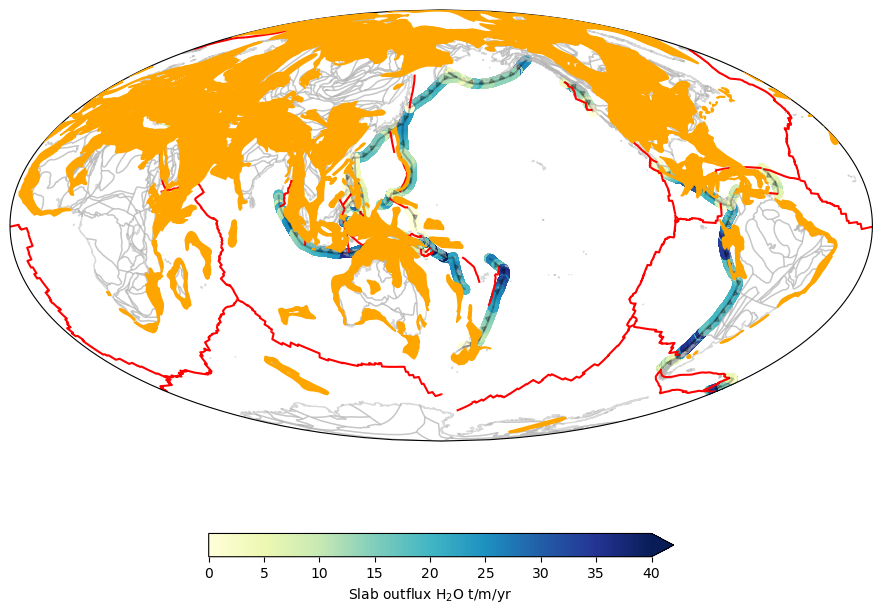

In [14]:
gplot.time = 0

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude=160))
ax.set_global()

# reconstruct platforms
reconstructed_platforms = model.reconstruct(platforms_filename, gplot.time)
gplot.plot_feature(ax, reconstructed_platforms, facecolor='orange', edgecolor='orange', zorder=10)

# plot subduction worms of water outflux
df_time = pd.read_parquet(subduction_filename.format(int(gplot.time)))
slab_outflux_area = calc_total_slab_outflux(df_time)
slab_outflux = slab_outflux_area*df_time['vel'] # Mt/m2 -> Mt/m/yr
sc = ax.scatter(df_time['lon'], df_time['lat'], c=slab_outflux*1e6,
                cmap='YlGnBu', vmin=0, vmax=40, transform=ccrs.PlateCarree())

gplot.plot_coastlines(ax, color='0.7', alpha=0.5)
gplot.plot_ridges(ax, color='red', linewidth=1.5)
gplot.plot_transforms(ax, color='red', linewidth=1.5)
# add_quiver(ax, reconstruction_time, color='k', alpha=0.33, zorder=3)
gplot.plot_trenches(ax, color='black', alpha=0.25)
gplot.plot_subduction_teeth(ax, color='black', alpha=0.25)

fig.colorbar(sc, shrink=0.4, orientation='horizontal', extend='max', label='Slab outflux H$_2$O t/m/yr')

Work out distance from carbonate platform to nearest trench segment

In [31]:
def get_carbonate_platform_coordinates(reconstructed_platforms, resX=0.2, resY=0.2):
    """
    Grids carbonate platform and extracts coordinates
    Assumes 0.2 degree resolution by default
    """
    
    nx, ny = int(360/resX), int(180/resY)

    platforms_grid = gplately.grids.rasterise(
        reconstructed_platforms,
        key=1,
        shape=(ny,nx)
    )
    
    xq, yq = np.meshgrid(np.linspace(-180,180,nx),
                         np.linspace(-90, 90, ny))
    
    mask_grid = platforms_grid > 0
    xcoords = xq[mask_grid]
    ycoords = yq[mask_grid]
    return xcoords, ycoords

In [32]:
def calc_distance_to_trench(df, lons, lats):
    """
    Calculates the distance to the nearest trench segment
    for given lons and lats
    """
    trench_xyz   = gplately.tools.lonlat2xyz(df['lon'], df['lat'], degrees=True)
    platform_xyz = gplately.tools.lonlat2xyz(lons, lats, degrees=True)
    
    tree = cKDTree(np.c_[platform_xyz])
    dist, index = tree.query(np.c_[trench_xyz])
    dist *= 6371
    return dist

def KD_dist(lons0, lats0, lons1, lats1):
    """
    Calculate the distance between two sets of lon,lat coordinates
    """
    xyz0 = gplately.tools.lonlat2xyz(lons0, lats0, degrees=True)
    xyz1 = gplately.tools.lonlat2xyz(lons1, lats1, degrees=True)
    
    tree = cKDTree(np.c_[xyz0])
    dist, index = tree.query(np.c_[xyz1])
    dist *= 6371
    return dist

### Plot water subduction influx

In [33]:
reconstruction_times = np.arange(0,start_time)

water_influx = np.zeros(reconstruction_times.size)
water_outflux = np.zeros(reconstruction_times.size)

for t, reconstruction_time in enumerate(reconstruction_times):
    # load subduction data
    df_time = pd.read_parquet(subduction_filename.format(reconstruction_time))
    slab_outflux_area = calc_total_slab_outflux(df_time)

    subduction_flux = (
        df_time['subduction_flux_crust_mean'] + 
        df_time['subduction_flux_sediment_mean'] +
        df_time['subduction_flux_lithosphere_mean']
    )

    water_outflux[t] = (slab_outflux_area*df_time['vel']*df_time['length']).sum()
    water_influx[t] = (subduction_flux*df_time['vel']*df_time['length']).sum()
    

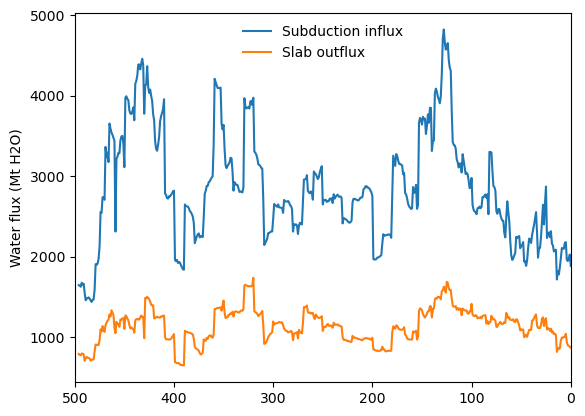

In [34]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlim=(500,0), ylabel='Water flux (Mt H2O)')
ax1.plot(reconstruction_times, water_influx, label='Subduction influx')
ax1.plot(reconstruction_times, water_outflux, label='Slab outflux')
ax1.legend(frameon=False)

### Find carbonate platform - subduction zone intersections

Extract points that lie within a carbonate platform (lons, lats) and find the distance to the subduction zone. Points within 400 km are considered to be arc related (rounded down from 436 km given in [Zahirovic et al. 2022](https://rmets.onlinelibrary.wiley.com/doi/10.1002/gdj3.146)).

In [35]:
def reconstruct_intersection_length(reconstruction_time, d_tol=400):
    # reconstruct platforms
    reconstructed_platforms = model.reconstruct(platforms_filename, reconstruction_time)
    
    # load subduction data
    df_time = pd.read_parquet(subduction_filename.format(reconstruction_time))
    slab_outflux_area = calc_total_slab_outflux(df_time)
    
    # find carbonate platform coordinates
    plons, plats = get_carbonate_platform_coordinates(reconstructed_platforms)

    # detect only carbonate platforms on the overriding plate
    subduction_norm = np.deg2rad(df_time['norm'])
    dlon = 0.1*np.sin(subduction_norm)
    dlat = 0.1*np.cos(subduction_norm)

    distance_to_trench      = KD_dist(plons, plats, df_time['lon'], df_time['lat'])
    distance_to_proj_trench = KD_dist(plons, plats, df_time['lon']+dlon, df_time['lat']+dlat)

    mask_dist = np.logical_and(distance_to_trench < d_tol, 
                               distance_to_trench > distance_to_proj_trench)

    return df_time['length'][mask_dist].sum()

In [39]:
intersection_length = Parallel(n_jobs=-3, verbose=1)(
    delayed(reconstruct_intersection_length)(time) for time in reconstruction_times)

intersection_length = np.array(intersection_length)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   19.9s
/Users/ben/miniforge3/envs/gplately2/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-3)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-3)]: Done 434 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-3)]: Done 497 out of 497 | elapsed:  4.0min finished


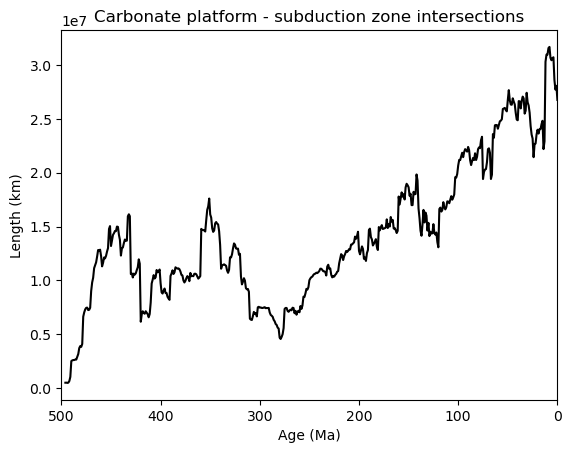

In [40]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlim=(500,0), 
                      title='Carbonate platform - subduction zone intersections',
                      xlabel='Age (Ma)', ylabel='Length (km)')
ax1.plot(reconstruction_times, intersection_length, c='k')

In [41]:
# reset to 0 Ma
reconstruction_time = 0
df_time = pd.read_parquet(subduction_filename.format(reconstruction_time))

slab_outflux_area = calc_total_slab_outflux(df_time)
slab_outflux = slab_outflux_area*df_time['vel'] # Mt/m2 -> Mt/m/yr

In [42]:
plons, plats = get_carbonate_platform_coordinates(reconstructed_platforms)

d_tol = 400
# detect only carbonate platforms on the overriding plate
subduction_norm = np.deg2rad(df_time['norm'])
dlon = 0.1*np.sin(subduction_norm)
dlat = 0.1*np.cos(subduction_norm)

distance_to_trench      = KD_dist(plons, plats, df_time['lon'], df_time['lat'])
distance_to_proj_trench = KD_dist(plons, plats, df_time['lon']+dlon, df_time['lat']+dlat)

mask_dist = np.logical_and(distance_to_trench < d_tol,
                           distance_to_trench > distance_to_proj_trench)

### Estimate H2O slab outflux and melt fraction

1. Integrate the slab outflux along trench length to get H2O Mt/yr.
2. Convert the area density of H2O area density to H2O wt % by assuming constant density of 3300 kg/m3 and integrate along the arc-depth of 125 km.
3. Estimate melt fraction after [Katz et al. 2003](https://doi.org/10.1029/2002GC000433) using a constant mantle temperature of 1350C and pressure range between 2.5-4.5 GPa.

In [46]:
# integrate H2O across trench length: Mt/m/yr -> Mt/yr
df_time = pd.read_parquet(subduction_filename.format(0))
integrated_slab_outflux = df_time['length']*slab_outflux
integrated_slab_outflux_platforms = integrated_slab_outflux[mask_dist].sum()
print("total H2O slab outflux near carbonate platforms {:.2f} Mt/yr".format(integrated_slab_outflux_platforms))

# constants
rho_m = 3300 # mantle density - kg/m3
d_arc = 125e3 # arc depth - m
P_range = [2.5, 3, 3.5, 4, 4.5] # pressure range - GPa
T_m = 1350 # mantle temperature - Celsius

# convert Mt/m2 -> wt % in the upper 125 km of the asthenospheric mantle (arc depth and above).
H2O_wt = 100*slab_outflux_area*1e6/(rho_m * d_arc * 1e-3)
print("mean H2O wt % near carbonate platforms {:.2f} wt %".format(H2O_wt[mask_dist].mean()))

# estimate melt fraction
F = np.zeros(H2O_wt.size)
for P in P_range:
    F += mlt.F_wet(P, T_m, H2O_wt)
F /= len(P_range)
print("mean melt fraction near carbonate platforms {:.3f}".format(F[mask_dist].mean()))

# calculate melting rate (melt fraction is in wt % so we convert to Mt/yr)
melting_rate = F/100*rho_m*d_arc*df_time['vel']*df_time['length']*1e-9
print("total melting rate {:.2f} Mt/yr".format(melting_rate.sum()))
print("total melting rate near carbonate platforms {:.2f} Mt/yr".format(melting_rate[mask_dist].sum()))

total H2O slab outflux near carbonate platforms 348.36 Mt/yr
mean H2O wt % near carbonate platforms 0.10 wt %
mean melt fraction near carbonate platforms 0.016
total melting rate 125.38 Mt/yr
total melting rate near carbonate platforms 51.04 Mt/yr


## Scale carbonate platform degassing through time

[Bekaert et al. 2021](http://doi.org/10.1146/annurev-earth-071620-055024) estimates the total outgassing from present-day subduction zones is 18 Mt C/year, and 20-30% of this is due to degassing from carbonate platforms (25% of 18 Mt is 4.5 Mt), then 4.5/`melting_rate` is the number to scale the carbonate platform degassing through time.

In [47]:
scale_degassing = 1.0/melting_rate[mask_dist].sum()
print("Scaling parameter for carbonate platform degassing {:.3f}".format(scale_degassing))

Scaling parameter for carbonate platform degassing 0.020


### Roll everything into a single function

Run in parallel over nominal time range

In [48]:
reconstruction_times = np.arange(0,start_time)

def reconstruct_carbonate_platform_degassing(reconstruction_time, d_tol=400):
    # reconstruct platforms
    reconstructed_platforms = model.reconstruct(platforms_filename, reconstruction_time)
    
    # load subduction data
    df_time = pd.read_parquet(subduction_filename.format(reconstruction_time))
    slab_outflux_area = calc_total_slab_outflux(df_time)
    
    # find carbonate platform - subduction zone intersections
    plons, plats = get_carbonate_platform_coordinates(reconstructed_platforms)
    
    # detect only carbonate platforms on the overriding plate
    subduction_norm = np.deg2rad(df_time['norm'])
    dlon = 0.1*np.sin(subduction_norm)
    dlat = 0.1*np.cos(subduction_norm)

    distance_to_trench      = KD_dist(plons, plats, df_time['lon'], df_time['lat'])
    distance_to_proj_trench = KD_dist(plons, plats, df_time['lon']+dlon, df_time['lat']+dlat)

    mask_dist = np.logical_and(distance_to_trench < d_tol, 
                               distance_to_trench > distance_to_proj_trench)
    

    # convert Mt/m2 -> wt % in the upper 125 km of the asthenospheric mantle (arc depth and above).
    H2O_wt = 100*slab_outflux_area*1e6/(rho_m * d_arc * 1e-3)

    # estimate melt fraction
    F = np.zeros(H2O_wt.size)
    for P in P_range:
        F += mlt.F_wet(P, T_m, H2O_wt)
    F /= len(P_range)

    # calculate melting rate (melt fraction is in wt % so we convert to Mt/yr)
    melting_rate = F/100*rho_m*d_arc*df_time['vel']*df_time['length']*1e-9
    melting_rate_platforms = melting_rate[mask_dist].sum()
    
    carbonate_platform_outflux = scale_degassing * melting_rate_platforms
    return carbonate_platform_outflux

In [49]:
degassing_rate = reconstruct_carbonate_platform_degassing(0)

assert np.isclose(degassing_rate, 1.0), "Present-day degassing rate is inconsistent"

In [50]:
degassing_rates = Parallel(n_jobs=-3, verbose=1)(
    delayed(reconstruct_carbonate_platform_degassing)(time) for time in reconstruction_times)

degassing_rates = np.array(degassing_rates)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
/Users/ben/miniforge3/envs/gplately2/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-3)]: Done 184 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-3)]: Done 434 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-3)]: Done 497 out of 497 | elapsed:  5.1min finished


Now multiply the degassing rates by min, mean, max endmembers (2.88, 4.7, 6.9 Mt C/a)

In [51]:
degassing_rates_min  = degassing_rates * 13.4
degassing_rates_mean = degassing_rates * 27.5
degassing_rates_max  = degassing_rates * 44.5

### Try scaling purely by arc length

i.e. 4.5/sum(Length)

In [53]:
df_time = pd.read_parquet(subduction_filename.format(0))
plons, plats = get_carbonate_platform_coordinates(reconstructed_platforms)
distance_to_trench = calc_distance_to_trench(df_time, plons, plats)

d_tol = 400
# detect only carbonate platforms on the overriding plate
subduction_norm = np.deg2rad(df_time['norm'])
dlon = 0.1*np.sin(subduction_norm)
dlat = 0.1*np.cos(subduction_norm)

distance_to_trench      = KD_dist(plons, plats, df_time['lon'], df_time['lat'])
distance_to_proj_trench = KD_dist(plons, plats, df_time['lon']+dlon, df_time['lat']+dlat)

mask_dist = np.logical_and(distance_to_trench < d_tol, 
                           distance_to_trench > distance_to_proj_trench)

scale_degassing2 = 1.0/df_time['length'][mask_dist].sum()
print("Scaling parameter for carbonate platform degassing {:.3e}".format(scale_degassing2))

Scaling parameter for carbonate platform degassing 3.736e-08


In [54]:
reconstruction_times = np.arange(0, start_time)

def reconstruct_carbonate_platform_degassing2(reconstruction_time, d_tol=400):
    # reconstruct platforms
    reconstructed_platforms = model.reconstruct(platforms_filename, reconstruction_time)
    
    # load subduction data
    df_time = pd.read_parquet(subduction_filename.format(reconstruction_time))
    slab_outflux_area = calc_total_slab_outflux(df_time)
    
    # find carbonate platform - subduction zone intersections
    plons, plats = get_carbonate_platform_coordinates(reconstructed_platforms)
    
    # detect only carbonate platforms on the overriding plate
    subduction_norm = np.deg2rad(df_time['norm'])
    dlon = 0.1*np.sin(subduction_norm)
    dlat = 0.1*np.cos(subduction_norm)

    distance_to_trench      = KD_dist(plons, plats, df_time['lon'], df_time['lat'])
    distance_to_proj_trench = KD_dist(plons, plats, df_time['lon']+dlon, df_time['lat']+dlat)

    mask_dist = np.logical_and(distance_to_trench < d_tol, 
                               distance_to_trench > distance_to_proj_trench)
    
    carbonate_platform_outflux = scale_degassing2 * df_time['length'][mask_dist].sum()
    return carbonate_platform_outflux

In [55]:
degassing_rate2 = reconstruct_carbonate_platform_degassing2(0)

assert np.isclose(degassing_rate2, 1), "Present-day degassing rate is inconsistent"

In [56]:
degassing_rates2 = Parallel(n_jobs=-3, verbose=1)(
    delayed(reconstruct_carbonate_platform_degassing2)(time) for time in reconstruction_times)

degassing_rates2 = np.array(degassing_rates2)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
/Users/ben/miniforge3/envs/gplately2/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-3)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-3)]: Done 434 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-3)]: Done 497 out of 497 | elapsed:  4.0min finished


Now multiply the degassing rates by min, mean, max endmembers (2.88, 4.7, 6.9 Mt C/a)

In [57]:
degassing_rates2_min  = degassing_rates2 * 13.4
degassing_rates2_mean = degassing_rates2 * 27.5
degassing_rates2_max  = degassing_rates2 * 44.5

### Read in climate data

From [Foster et al. 2017](https://doi.org/10.1038/ncomms14845)

In [58]:
df_foster = pd.read_csv("Data/Foster_etal_carbon_cycles_420Ma_to_present_NatComms2017-s3.csv", skiprows=1)

In [59]:
# load Ratschbacher2019 continental arc outgassing curve

df_rat = pd.read_csv("Data/Ratschbacher2019-fig4_arc_CO2.csv", header=[0,1], index_col=0)
df_rat = df_rat['Global CO2 flux from cont. arcs (Mt C/yr)']

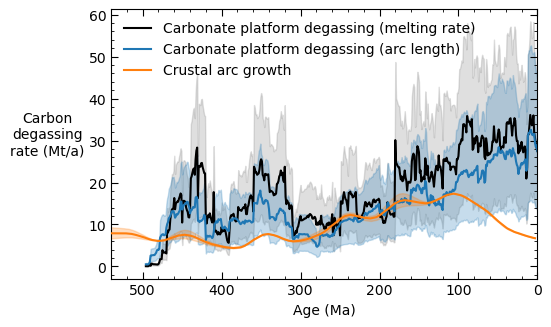

In [60]:
fig = plt.figure(figsize=(5.5,3.5))
ax1 = fig.add_subplot(111, xlabel='Age (Ma)', xlim=[540,0])
ax1.set_ylabel("Carbon\ndegassing\nrate (Mt/a)", rotation=0)
ax1.yaxis.set_label_coords(-0.15, 0.45)
ax1.tick_params(direction="in", which='major', length=5,   top=True, right=True)
ax1.tick_params(direction='in', which='minor', length=2.5, top=True, right=True)
ax1.minorticks_on()

ax1.fill_between(reconstruction_times,
                 degassing_rates_min,
                 degassing_rates_max, color='0.5', alpha=0.25)
ax1.fill_between(reconstruction_times,
                 degassing_rates2_min, 
                 degassing_rates2_max, color='C0', alpha=0.25)
ax1.fill_between(df_rat.index, df_rat['min'], df_rat['max'], color='C1', alpha=0.25, zorder=1)

ax1.plot(reconstruction_times, degassing_rates_mean, c='k', label='Carbonate platform degassing (melting rate)')
ax1.plot(reconstruction_times, degassing_rates2_mean, c='C0', label='Carbonate platform degassing (arc length)')
ax1.plot(df_rat.index, df_rat['mean'], c='C1', label='Crustal arc growth',zorder=3)

# ax2 = ax1.twinx()
# ax2.set_ylabel('CO$_2$ ppm')
# ax2.plot(df_foster['Age (Ma)'], df_foster['pCO2 probability maximum'], c='0.5', linestyle='--',
#          label='Atmospheric CO$_2$ (Foster et al. 2017)')
ax1.legend(loc='upper left', frameon=False)
fig.savefig("figures/carbonate_platform_degassing.pdf", dpi=300, bbox_inches='tight')

In [61]:
np.savetxt("figures/carbonate_platform_degassing.csv", np.c_[reconstruction_times, degassing_rates, degassing_rates2], delimiter=',',
           header='Age (Ma),Carbonate platform degassing (Mt/yr),Carbonate platform degassing Wong (Mt/yr)', comments='')